<a href="https://colab.research.google.com/github/tedteske/DerbyStats/blob/master/Pack_27_Derbystats_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Pack 27 Pinewood Derby 2020 Results

First, import the libraries we'll need and load the CSV results files into a Pandas dataframe.

In [0]:
#see https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import glob
import os
import pandas as pd
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns 
sns.set(rc={'figure.figsize':(8,5)})
plt.rcParams["font.family"] = "serif"

import warnings 
warnings.simplefilter('ignore')

def top_times(df, filter_dict=None, means=True, top=10):
    
    if filter_dict:
        df = df[df.isin(filter_dict).sum(1) == len(filter_dict.keys())]
        # adapted from https://stackoverflow.com/questions/38137821
    
    df = df[['Car', 'Last Name', 'First Name', 'Lane', 'Time']]
    
    if means:
        aggs = {'Time':['mean','std']}
        df = df.groupby(['Car','Last Name','First Name']).agg(aggs)
        df.columns = ['Time', 'Stdev']
        
    mu = df['Time'].mean()
    stdev = df['Time'].std()
    df['Z-score'] = (df['Time'] - mu)/stdev
    
    df = df.sort_values('Time')
    df = df.head(top)
    df = df.reset_index()
    df.index += 1 

    return df

def compare_hist(df, comps_dict, filter_dict=None, 
                 title=None, hist=True, norm_hist=True, kde=True, fit=None):

    if filter_dict:
        df = df[df.isin(filter_dict).sum(1) == len(filter_dict.keys())]
    
    plots = len(comps_dict)
    fig, axes = plt.subplots(plots, 1, 
                             figsize=(10, plots * 10/1.6), 
                             sharex=True)
    if plots > 1:
        axes = axes.flat
    else:
        axes = [axes]
    for ax, column in zip(axes, comps_dict):
        for value in comps_dict[column]:
            try:
                fseries = df[df[column].isin([value])]['Time']
            except:
                column = column[:-1]
                fseries = df[df[column].isin([value])]['Time']
            sns.distplot(fseries,
                         label=value,
                         hist=hist,
                         norm_hist=norm_hist,
                         kde=kde, kde_kws={'shade':True},
                         fit=fit,
                         bins=None,
                         ax=ax, axlabel=False)
            if kde: 
                c = ax.get_lines()[-1].get_c() 
                ax.axvline(fseries.mean(), color=c, linestyle='--')
                legend_title = "------  averages" 
            else: 
                legend_title = None
            if norm_hist:
                ax.set(ylabel='relative frequency')
            else: 
                ax.set(ylabel='frequency')
            leg = ax.legend(title=legend_title, title_fontsize='medium')
            leg._legend_box.align = "left"

    axes[-1].set(xlabel='time (sec)')
    if title: 
        fig.suptitle(title)
        fig.subplots_adjust(top=0.93)
    plt.subplots_adjust(hspace=0.07)
    plt.show()

In [0]:
data_dir = "/content/gdrive/My Drive/Colab Notebooks/scouts/pack 27 2020"
year_dirs = ["2018","2019","2020"]
col_dict = {"Heat#":"Heat",
            "Car#":"Car", 
            "Avg MPH":"MPH" }

temp_list = []

for year_dir in year_dirs:

    results_files = glob.glob(data_dir + "/" + year_dir + "/" + "*.csv")

    for results_file in results_files:
        df = pd.read_csv(results_file, index_col=None, header=0)
        results_file = os.path.basename(results_file) 
        df['Round'] = results_file.replace('.csv', '')
        df['Year'] = year_dir
        df.rename(columns=col_dict, inplace=True)
        temp_list.append(df)

all_results_df = pd.concat(temp_list, axis = 0, ignore_index = True)
all_results_df = all_results_df.drop(all_results_df[all_results_df["Time"].isnull()].index, axis=0)

#to scan for misspelled names
#names = ['Last Name','First Name']
#all_results_df[names].groupby(names).agg('sum').iloc[50:]

Names_Fixes = [['Adams', 'Johnathan', 'Adams', 'Jonathan'],
               ['Arreage','Angel', 'Arreaga','Angel'],
               ['Arreage', 'Axel', 'Arreaga', 'Axel'],
               ['Arreaga', 'Axle', 'Arreaga', 'Axel'],
               ['Callaway', 'Nard', 'Nard', 'Callaway'],
               ['Douthitt', 'Briana Lynn', 'Douthitt', 'Brianna Lynn'],
               ['Fanken', 'Sully', 'Franken','Sully'],
               ['McCAbe', 'Madison', 'McCabe', 'Madison'],
               ['Marriot', 'Zayla' ,'Merriott','Zayla' ],
               ['Rickets',	'Sean', 'Ricketts','Sean' ],
               ['Teske', 'Victor','Teske', 'Viktor'],
               ['Thompson Brylee', 'Brylee', 'Thompson', 'Brylee'],
               ['Oliver', 'Pool', 'Pool','Oliver']]

for i in Names_Fixes:
    all_results_df.loc[(all_results_df['Last Name'] == i[0]) & 
                        (all_results_df['First Name'] == i[1]),
                    ['Last Name', 'First Name']]=[i[2], i[3]]

Check the first 5 rows to make sure the data loaded OK.

In [0]:
all_results_df.head()

,Heat,Lane,Last Name,First Name,Car,Time,Place,MPH,Round,Year
0,1,1,Ramirez,Landen,4,3.3239,4.0,148.72,Finals,2018
1,1,2,Thompson,Brock,10,3.3816,6.0,146.18,Finals,2018
2,1,3,Holland,Dristan,19,3.3016,3.0,149.72,Finals,2018
3,1,4,Cundiff,Cade,30,3.2704,2.0,151.15,Finals,2018
4,1,5,Evers,Justin,40,3.3242,5.0,148.70,Finals,2018


### Preliminary Rounds

Let's compare the preliminary rounds with last year. First, run the usual stats.

In [0]:
prelims = ['Lion', 'Tiger', 'Wolf', 'Bear', 'Webelo', 'AOL']
prelims_df = all_results_df[all_results_df.Round.isin(prelims)]
prelims_df.groupby(['Year'])['Time'].describe().round(3).T

Year,2019,2020
count,324.000,288.000
mean,3.436,3.364
std,0.260,0.174
min,3.156,3.126
25%,3.269,3.233
50%,3.371,3.339
75%,3.523,3.432
max,4.948,4.280


It appears that 2020 was an improvement over 2019. Test whether the difference is significant or just chance.

In [0]:
stats.ttest_ind(prelims_df[prelims_df.Year.isin(['2019'])]['Time'], 
                prelims_df[prelims_df.Year.isin(['2020'])]['Time'])

Ttest_indResult(statistic=4.006089398234697, pvalue=6.935678520563545e-05)

Since pvalue < 0.05, we can reject the null hypothesis that the samples (2019 and 2020) are drawn from the same process. In other words, 2020 was a *significant* improvement over 2019.

Let's see what the distribtion of times looks like by drawing a histogram, or frequency distribution.

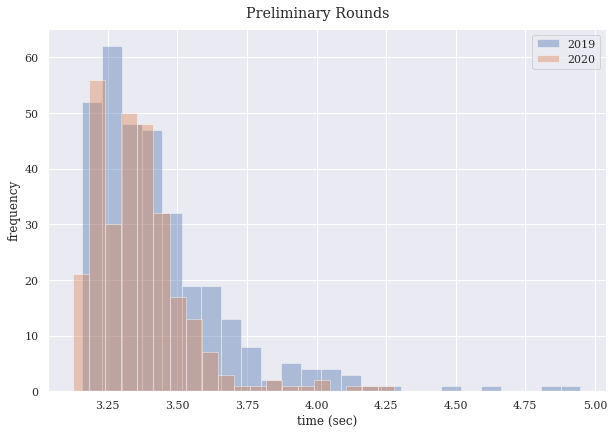

In [0]:
comps = {'Year' : ['2019', '2020']}
compare_hist(prelims_df, comps, title="Preliminary Rounds",
         hist=True, norm_hist=False, kde=False)

As there were fewer competitors in 2020, let's normalize the results. Also, to facilitate year-to-year comparison, we'll smooth the histograms and add lines representing average time by year.

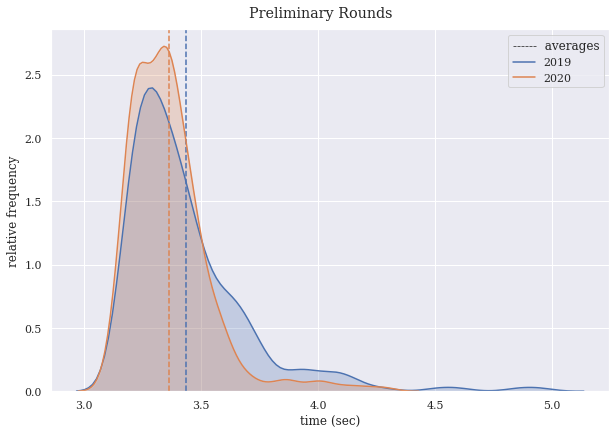

In [0]:
comps = {'Year' : ['2019', '2020']}
compare_hist(prelims_df, comps, title="Preliminary Rounds",
         hist=False, norm_hist=True, kde=True)

We see that 2020 was not only faster but more consistent: the times were distributed more tightly around the average.

2019 vs 2020 broken down by den.

In [0]:
prelims_df.groupby(['Year', 'Round'])['Time'].describe().round(3).T

Year     2019                          ...    2020                        
Round     AOL    Bear    Lion   Tiger  ...    Lion   Tiger  Webelo    Wolf
count  42.000  72.000  78.000  54.000  ...  24.000  96.000  60.000  48.000
mean    3.408   3.522   3.442   3.442  ...   3.587   3.350   3.365   3.353
std     0.243   0.375   0.217   0.252  ...   0.395   0.127   0.143   0.080
min     3.172   3.171   3.156   3.206  ...   3.185   3.126   3.195   3.182
25%     3.248   3.273   3.248   3.315  ...   3.222   3.247   3.237   3.323
50%     3.346   3.379   3.440   3.376  ...   3.473   3.343   3.326   3.352
75%     3.485   3.667   3.574   3.437  ...   3.920   3.459   3.464   3.407
max     4.146   4.948   3.978   4.275  ...   4.280   3.629   3.695   3.472

[8 rows x 12 columns]

Average Time by car in the prelims, the top 10. 
* Z-score, or standard score, indicates how fast each car was that in terms of standard deviations from the overall average.See https://en.wikipedia.org/wiki/Standard_score for more info.
* If `means=True`, Time and Stdev are the mean time and standard deviation for that car.

In [0]:
filter_dict = {'Year' :['2020']}
top_times(prelims_df, filter_dict, means=True, top=10)

,Car,Last Name,First Name,Time,Stdev,Z-score
1,56,Schoonover,Adelyn,3.141383,0.004749,-1.312068
2,54,Schoonover,Isaac,3.183133,0.023797,-1.065954
3,26,Townsend,Kolby,3.184133,0.042460,-1.060059
4,44,Kunkel,Tristan,3.188883,0.008273,-1.032058
5,2,Evers,Charlie,3.192350,0.021509,-1.011622
6,55,Schoonover,Aubrey,3.192467,0.042829,-1.010935
7,62,Hobson,Atticus,3.205767,0.011815,-0.932532
8,9,Wilson,Joshua,3.219917,0.012830,-0.849119
9,63,Hobson,Lucas,3.220367,0.003140,-0.846466
10,61,Hobson,Everett,3.222833,0.017074,-0.831925


And here are the top 10 individual Times in the prelims.

In [0]:
filter_dict = {'Year' :['2020']}
top_times(prelims_df, filter_dict, means=False)

,index,Car,Last Name,First Name,Lane,Time,Z-score
1,971,55,Schoonover,Aubrey,6,3.1256,-1.371733
2,960,56,Schoonover,Adelyn,1,3.1347,-1.319364
3,881,56,Schoonover,Adelyn,6,3.1380,-1.300372
4,916,56,Schoonover,Adelyn,5,3.1403,-1.287136
5,955,56,Schoonover,Adelyn,2,3.1425,-1.274475
6,933,56,Schoonover,Adelyn,4,3.1450,-1.260088
7,944,56,Schoonover,Adelyn,3,3.1478,-1.243974
8,1131,54,Schoonover,Isaac,4,3.1528,-1.215200
9,1179,26,Townsend,Kolby,4,3.1567,-1.192756
10,1165,26,Townsend,Kolby,2,3.1625,-1.159377


Notice that car 55 had the fastest individual Time, even though it had the 6th fastest average Time. Moreover, it had the highest standard deviation of any car in the top 10. Here are all its individual times.

In [0]:
prelims_df[prelims_df.Car.isin([55])].sort_values('Lane')

,Heat,Lane,Last Name,First Name,Car,Time,Place,MPH,Round,Year
954,14,1,Schoonover,Aubrey,55,3.2161,2.0,222.60,Tiger,2020
949,13,2,Schoonover,Aubrey,55,3.2048,1.0,223.39,Tiger,2020
938,11,3,Schoonover,Aubrey,55,3.2490,2.0,220.35,Tiger,2020
927,9,4,Schoonover,Aubrey,55,3.1949,1.0,224.08,Tiger,2020
910,6,5,Schoonover,Aubrey,55,3.1644,1.0,226.24,Tiger,2020
971,16,6,Schoonover,Aubrey,55,3.1256,1.0,229.05,Tiger,2020


Average Time by car in the 2019 prelims, the top 10.

In [0]:
filter_dict = {'Year' :['2019']}
top_times(prelims_df, filter_dict, means=True)

,Car,Last Name,First Name,Time,Stdev,Z-score
1,30,Schoonover,Aubrey,3.177917,0.020135,-1.038902
2,31,Schoonover,Adelyn,3.180867,0.026143,-1.027049
3,14,Holt,George,3.186500,0.017309,-1.004415
4,43,Evers,Charlie,3.202167,0.023047,-0.941469
5,50,Cundiff,Cade,3.203967,0.009280,-0.934237
6,51,Cundiff,Reed,3.212033,0.007044,-0.901826
7,15,Ferguson,Eli,3.216883,0.017884,-0.882340
8,63,Mulgrew,Jackson,3.222100,0.018453,-0.861380
9,16,Kunkel,Tristan,3.229817,0.030662,-0.830375
10,46,Bramlett,Hudson,3.230933,0.019624,-0.825889


And here are the top 10 individual Times in the 2019 prelims.

In [0]:
filter_dict = {'Year' :['2019']}
top_times(prelims_df, filter_dict, means=False)

,index,Car,Last Name,First Name,Lane,Time,Z-score
1,421,31,Schoonover,Adelyn,2,3.1564,-1.077618
2,379,30,Schoonover,Aubrey,2,3.1629,-1.052610
3,410,30,Schoonover,Aubrey,3,3.1644,-1.046839
4,392,31,Schoonover,Adelyn,3,3.1661,-1.040298
5,363,30,Schoonover,Aubrey,4,3.1707,-1.022600
6,242,14,Holt,George,3,3.1708,-1.022215
7,401,31,Schoonover,Adelyn,6,3.1710,-1.021446
8,116,54,Evers,Justin,3,3.1715,-1.019522
9,430,31,Schoonover,Adelyn,5,3.1733,-1.012596
10,286,14,Holt,George,5,3.1738,-1.010673


Of those scouts who competed in both 2019 and 2020, who improved the most?

In [0]:
name_columns = ['Last Name','First Name']

p2020_df = top_times(prelims_df, {'Year':['2020']}, means=True, top=None)
p2019_df = top_times(prelims_df, {'Year':['2019']}, means=True, top=None)

inner_df = pd.merge(left=p2020_df, right=p2019_df, 
                    left_on=name_columns, right_on=name_columns,
                    suffixes=('_2020', '_2019'))

inner_df.drop(['Car_2020','Car_2019', 'Stdev_2020', 'Stdev_2019',
               'Z-score_2020', 'Z-score_2019'], axis=1, inplace=True)

inner_df['Diff'] = inner_df['Time_2020'] - inner_df['Time_2019']
inner_df = inner_df.sort_values('Diff').head(10)
inner_df = inner_df.reset_index()
inner_df.index += 1 
inner_df

,index,Last Name,First Name,Time_2020,Time_2019,Diff
1,19,Ricketts,Sean,3.382117,4.464883,-1.082767
2,11,Tipton,Zechariah,3.315933,3.656217,-0.340283
3,14,Douthitt,Savannah Rose,3.347433,3.664633,-0.317200
4,8,McCabe,Madison,3.241033,3.528417,-0.287383
5,1,Schoonover,Isaac,3.183133,3.377300,-0.194167
6,24,Franken,Ville,3.465950,3.646750,-0.180800
7,16,Shelton,Starry,3.355100,3.502933,-0.147833
8,9,Arreaga,Angel,3.241317,3.388750,-0.147433
9,13,Douthitt,Adam,3.331617,3.427967,-0.096350
10,17,Franken,Sully,3.375933,3.470633,-0.094700


### Finals Rounds

Now let's compare the Finals round with last year. First, run the usual stats.

In [0]:
finals = ['Finals']
finals_df = all_results_df[all_results_df.Round.isin(finals)]
finals_df.groupby(['Year'])['Time'].describe().round(3).T

Year,2018,2019,2020
count,108.000,108.000,108.000
mean,3.295,3.226,3.227
std,0.093,0.048,0.069
min,3.183,3.134,3.122
25%,3.234,3.199,3.183
50%,3.268,3.216,3.209
75%,3.310,3.251,3.244
max,3.618,3.392,3.453


It appears that both 2020 and 2019 were faster than 2018. Test whether the differences are significant or just chance.

In [0]:
stats.ttest_ind(finals_df[finals_df.Year.isin(['2019'])]['Time'],
                finals_df[finals_df.Year.isin(['2020'])]['Time'])

Ttest_indResult(statistic=-0.017378530761289736, pvalue=0.9861508281354359)

Since pvalue is high, we cannot reject the null hypothesis that the samples (2019 and 2020) are drawn from the same process. In other words, there was no significant different between the 2019 and 2020 finals.

In [0]:
stats.ttest_ind(finals_df[finals_df.Year.isin(['2018'])]['Time'],
                finals_df[finals_df.Year.isin(['2019'])]['Time'])

Ttest_indResult(statistic=6.796968980760401, pvalue=1.045463263910283e-10)

Since pvalue < 0.05, we can reject the null hypothesis that the samples (2018 and 2019) are drawn from the same process. In other words, the 2019 finals were significantly faster than 2018.

You can see below that 2019 and 2020 have practically the same average and mostly overlapping distributions. Both improve one 2018.

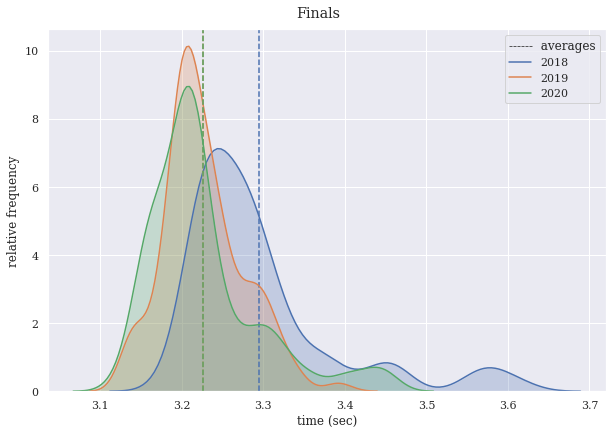

In [0]:
comps = {'Year' : [ '2018', '2019', '2020' ]}
compare_hist(finals_df, comps, title="Finals",
         hist=False, norm_hist=True, kde=True)

Average Time by car in the 2020 finals, the top 10.

In [0]:
filter_dict = {'Year' :['2020']}
top_times(finals_df, filter_dict,means=True)

,Car,Last Name,First Name,Time,Stdev,Z-score
1,56,Schoonover,Adelyn,3.150633,0.008720,-1.112821
2,2,Evers,Charlie,3.158067,0.012404,-1.003829
3,26,Townsend,Kolby,3.166767,0.006481,-0.876265
4,54,Schoonover,Isaac,3.177400,0.015201,-0.720353
5,55,Schoonover,Aubrey,3.179983,0.034767,-0.682475
6,44,Kunkel,Tristan,3.196050,0.021946,-0.446896
7,62,Hobson,Atticus,3.204467,0.014217,-0.323486
8,42,Cundiff,Cade,3.205150,0.016814,-0.313467
9,63,Hobson,Lucas,3.205967,0.002664,-0.301492
10,3,Arreaga,Angel,3.213050,0.019758,-0.197632


Average Time by car in the 2019 finals, the top 10.

In [0]:
filter_dict = {'Year' :['2019']}
top_times(finals_df, filter_dict,means=True)

,Car,Last Name,First Name,Time,Stdev,Z-score
1,30,Schoonover,Aubrey,3.146733,0.012968,-1.811702
2,31,Schoonover,Adelyn,3.176533,0.026556,-1.133917
3,51,Cundiff,Reed,3.183350,0.013195,-0.978875
4,43,Evers,Charlie,3.187033,0.025281,-0.895100
5,14,Holt,George,3.198600,0.012189,-0.632022
6,16,Kunkel,Tristan,3.198800,0.008713,-0.627473
7,50,Cundiff,Cade,3.205800,0.008255,-0.468262
8,15,Ferguson,Eli,3.209633,0.006785,-0.381075
9,46,Bramlett,Hudson,3.218517,0.021625,-0.179028
10,63,Mulgrew,Jackson,3.226400,0.018332,0.000274


### Lanes, Ages and the Schoonover Effect

Are there any differences among the lanes? First run the usual stats and plot the distributions.

In [0]:
lanes_df = prelims_df[prelims_df.Year.isin(['2020'])][['Lane','Time']]
lanes_df.groupby(['Lane']).describe().round(4).T

Lane              1        2        3        4        5        6
Time count  48.0000  48.0000  48.0000  48.0000  48.0000  48.0000
     mean    3.3741   3.3845   3.3573   3.3565   3.3494   3.3619
     std     0.1874   0.1954   0.1710   0.1752   0.1420   0.1734
     min     3.1347   3.1425   3.1478   3.1450   3.1403   3.1256
     25%     3.2494   3.2328   3.2368   3.2255   3.2302   3.2417
     50%     3.3624   3.3498   3.3276   3.3299   3.3302   3.3276
     75%     3.4351   3.4645   3.4319   3.4214   3.4256   3.4273
     max     4.2796   4.1866   4.1112   4.0393   3.8615   3.9871

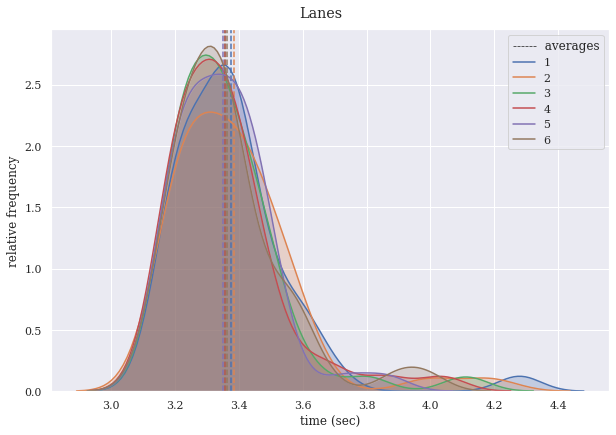

In [0]:
comps = {'Lane' : [1,2,3,4,5,6]}
compare_hist(lanes_df, comps, title="Lanes",
         hist=False, norm_hist=True, kde=True)

Not a lot of difference. 

Next, run a test between each pair of lanes to determine if the lane means are significantly different.

In [0]:
lanes = [1,2,3,4,5,6]

b = [[i, j] for i in lanes for j in lanes]
combos = []
for i in b:
    if i[0]<i[1]: 
        combos.append(i)

pvalues = []
for i in combos:
    e = lanes_df["Time"][lanes_df["Lane"]==i[0]]
    f = lanes_df["Time"][lanes_df["Lane"]==i[1]]
    pvalue = round(stats.ttest_ind(e, f)[1],4)
    pvalues.append(pvalue)

pd.DataFrame({'Lane Pair': combos,
              'P-value' : pvalues}).sort_values('P-value')


,Lane Pair,P-value
7,"[2, 5]",0.3165
6,"[2, 4]",0.4619
3,"[1, 5]",0.4690
5,"[2, 3]",0.4697
8,"[2, 6]",0.5506
2,"[1, 4]",0.6367
1,"[1, 3]",0.6480
14,"[5, 6]",0.6994
4,"[1, 6]",0.7423
0,"[1, 2]",0.7901


Since, for each pair of lanes, the probability is high (p-value>0.05) that the mean Time difference is chance, we can conclude there is no significant difference among the lanes.

#### The Schoonover Effect

Yes, there is one, and it's measurable and significant. On average and when controlling for scouts' ages and lanes, having the last name 'Schoonover' reduces the Time by around 0.22 seconds in both 2019 and 2020. See the coefficient for `Schoonover` in the results below.

Also note that each additional year in a scout's age reduces her time by around 0.03 seconds. This result is also significant.

In [0]:
df = prelims_df[prelims_df.Year.isin(['2020'])]

for i in zip(['Lion', 'Tiger', 'Wolf', 'Bear', 'Webelo', 'AOL'], range(6)):
    df.loc[df['Round']==i[0],'Age'] = i[1]

for i in [2,3,4,5,6]:
    df.loc[df['Lane']==i,'Lane'+str(i)] = 1

df.loc[df['Last Name']=='Schoonover','Schoonover'] = 1

for n in ['Age', 'Lane2','Lane3','Lane4','Lane5','Lane6', 'Schoonover']:
    df[n].fillna(0,inplace=True)

reg_form = "Time ~ Age + Lane2 + Lane3 + Lane4 + Lane5 + Lane6 + Schoonover"
result = sm.ols(formula=reg_form, data=df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     7.038
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           9.64e-08
Time:                        00:48:52   Log-Likelihood:                 119.20
No. Observations:                 288   AIC:                            -222.4
Df Residuals:                     280   BIC:                            -193.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4547      0.028    124.164      0.0

### Distributional Analysis and Fastest Possible Time

Let's look again at the histogram for the preliminary rounds.

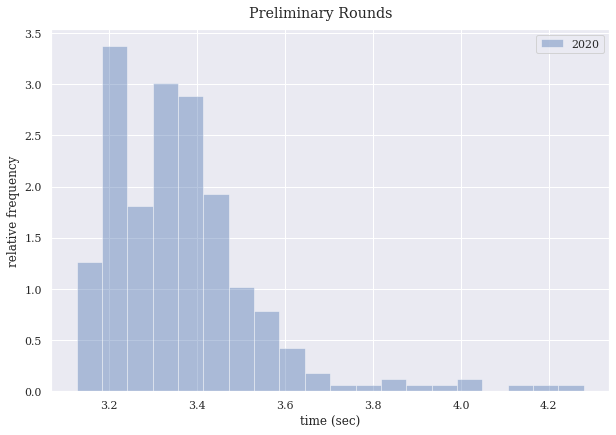

In [0]:
comps = {'Year' : ['2020']}
compare_hist(prelims_df, comps, title="Preliminary Rounds",
         hist=True, norm_hist=True, kde=False)

Can we say with confidence that the preliminaries' times are normally distributed (i.e. follow a bell curve)? Do a test for normality.

In [0]:
times = prelims_df[prelims_df.Year.isin(['2020'])]['Time']
stats.normaltest(times)

NormaltestResult(statistic=138.7593010969528, pvalue=7.3926579172741614e-31)

Since the above p-value < 5% , we can reject the null hypothesis that Times are distributed normally. 

The histogram appears to have a long right tail and a hard boundary on the left. Perhaps a lognormal distribution is more appropriate. Superimpose a lognormal probability density function to the histogram and check visually for goodness of fit.

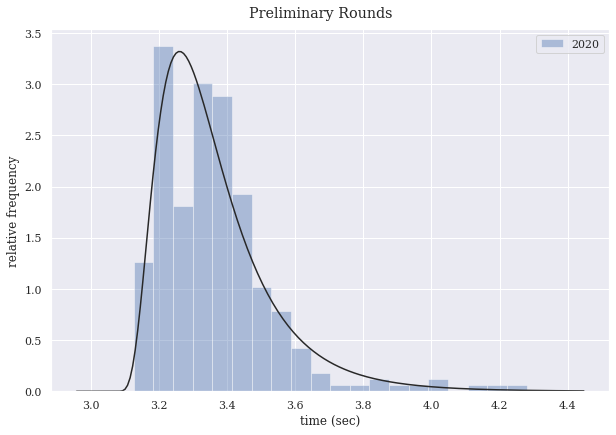

In [0]:
comps = {'Year' : ['2020']}
compare_hist(prelims_df, comps, title="Preliminary Rounds",
         hist=True, norm_hist=True, kde=False, fit=stats.lognorm)

The curve looks to fit the data well. I.e. the data appear to follow a lognormal distribution. Test for goodness of fit.

In [0]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html#scipy.stats.kstest
stats.kstest(times, "lognorm", stats.lognorm.fit(times))

KstestResult(statistic=0.06400834257575488, pvalue=0.18090164259893818)

Since the above p-value > 5% , we cannot reject the null hypothesis that Times follow a lognormal distribution. Also we know that simulating the track physics yields a lognormal distribution of race times. See https://github.com/tedteske/DerbySim/blob/master/DerbySim.ipynb for details.

Now, estimate the parameters of that distribution, and plot a historgram of random draws from it to see if it resembles the original data. 

shape =  0.532
lower bound =  3.0641
distance from lower bound to median =  0.2602




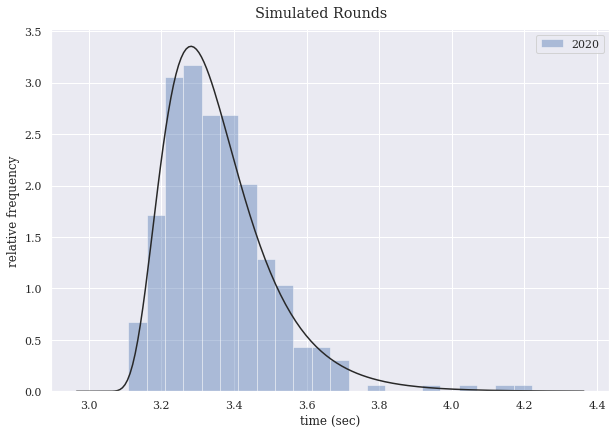

In [0]:
shape, floor, median = stats.lognorm.fit(times)

print("shape = ", shape.round(4))
print("lower bound = ", floor.round(4))
print("distance from lower bound to median = ", median.round(4))
print("\n")

dist = []
for i in range(324):
    x = stats.lognorm.rvs(s=shape, loc=floor, scale=median)
    dist.append(['2020', x])

df = pd.DataFrame(dist, columns = ['Year', 'Time'])  

comps = {'Year' : ['2020']}
compare_hist(df, comps_dict=comps, title="Simulated Rounds",
         hist=True, norm_hist=True, kde=False, fit=stats.lognorm)

Yes, sure does. 

If this curve then is representative, then what is the probability of some car out of this group running a time better than 3.2 seconds?

In [0]:
#https://matthew-brett.github.io/teaching/on_cdfs.html
stats.lognorm.cdf(x=3.2, s=shape, loc=floor, scale=median).round(4)

0.111

What about the probability of running a time better than 3.1 seconds?

In [0]:
stats.lognorm.cdf(x=3.1, s=shape, loc=floor, scale=median).round(4)

0.0001

...which is consistent with the lower bound of the distribution above.  Note that this is also consistent with the fastest possible time (with stock wheels) of 3.05. 

See again https://github.com/tedteske/DerbySim/blob/master/DerbySim.ipynb for details.